# Applied Machine Learning Project: Cyberbullying Detection

In [9]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [10]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/cyberbullying_tweets.csv')  # Importing the dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Quick Data Check

In [11]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [9]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.6 MB/s eta 0:00:00


## Data Preprocessing

In [13]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import demoji
import string

In [14]:
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [12]:
!python -m nltk.downloader stopwords

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm',
                  'im', 'll', 'y', 've', 'u', 'ur', 'don',
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat',
                  'de', 're', 'amp', 'will', 'wa', 'e', 'like'])
stemmer = SnowballStemmer('english')
def clean_text(text):

    # Remove Hashtag, Mention, URLs
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', text)
    text = " ".join(text.split())

    # Make all text lowercase
    text = text.lower()

    # Stemming
    text = " ".join([stemmer.stem(word) for word in text.split()])

    # Removing Punctuations
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)

    # Removing stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

    # Taking care of emojis
    emoji = demoji.findall(text)
    for emot in emoji:
        text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

    return text

In [16]:
df['cleaned_text'] = df['tweet_text'].apply(lambda text: clean_text(text))  # Applying the cleaning to the text data

In [17]:
df.head()

,tweet_text,cyberbullying_type,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,whi white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,gio meh thank head concern anoth angri dude tw...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account islam lies


In [18]:
df.isnull().sum()  # Checking for missing values

tweet_text            0
cyberbullying_type    0
cleaned_text          0
dtype: int64

In [19]:
df['cleaned_text'].duplicated().sum() # Checking for duplicate values

2887

In [20]:
df.drop_duplicates("cleaned_text", inplace = True)

In [21]:
df['cleaned_text'].str.isspace().sum()     # Checking for tweets with only whitespaces

0

In [22]:
df = df[df["cyberbullying_type"]!="other_cyberbullying"]

In [23]:
df['cyberbullying_type'].value_counts()

religion             7946
age                  7887
ethnicity            7797
not_cyberbullying    7670
gender               7637
Name: cyberbullying_type, dtype: int64

<Axes: xlabel='cyberbullying_type', ylabel='count'>

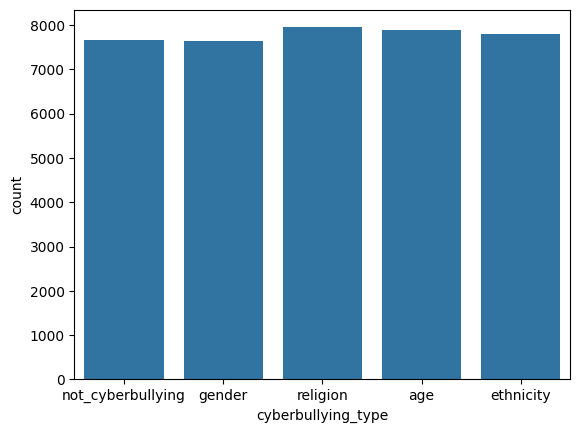

In [24]:
sns.countplot(data = df, x = 'cyberbullying_type')

This is a balanced dataset.

In [25]:
# Plotting the top 15 words of each cyberbullying type
for cyber_type in df.cyberbullying_type.unique():

    top50_word = df.cleaned_text[df.cyberbullying_type==cyber_type].str.split(expand=True).stack().value_counts()[:15]

    fig = px.bar(top50_word, color=top50_word.values, color_continuous_scale=px.colors.sequential.RdPu, custom_data=[top50_word.values])
    fig.update_traces(marker_color='red')
    fig.update_traces(hovertemplate='<b>Count: </b>%{customdata[0]}')
    fig.update_layout(title=f"Top 15 words for {cyber_type}",
                     template='simple_white',
                     hovermode='x unified')
    fig.show()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
X = df['cleaned_text']  # Feature (raw data)
y = df['cyberbullying_type']  # Target Label

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
# Performing the train|test split. This test set is essentially a hold out test set as we'll be performing Cross Validation
# using Grid Search which will split our training data into a training and validation split

In [29]:
tfidf = TfidfVectorizer(max_features = 5000)  # Using the TF - IDF Vectorizer to extract top 5000 most important features
# from the text data

In [30]:
# Feature Extraction
X_train_tfidf = tfidf.fit_transform(X_train)  # Creating the vocabulary only from the training set to avoid data leakage from
X_test_tfidf = tfidf.transform(X_test)        # the test set.

In [31]:
X_train_tfidf  # Sparse Matrix is created to save memory since many values are close to 0

<35043x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 403374 stored elements in Compressed Sparse Row format>

In [32]:
X_test_tfidf  # Sparse Matrix

<3894x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 44224 stored elements in Compressed Sparse Row format>

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tfidf_array_train = X_train_tfidf.toarray()   # Converting the sparse matrix to a numpy array (dense matrix)
tfidf_array_test = X_test_tfidf.toarray()     # Converting the sparse matrix to a numpy array (dense matrix)
scaled_X_train = scaler.fit_transform(tfidf_array_train)  # Fitting on only training data to avoid data leakage from test data
scaled_X_test = scaler.transform(tfidf_array_test) # and then tranforming both training and testing data

In [34]:
# Performing Dimensionality Reduction using Principal Component Analysis
from sklearn.decomposition import PCA
NUM_COMPONENTS = 5000  # Total number of features
pca = PCA(NUM_COMPONENTS)
reduced = pca.fit(scaled_X_train)

In [35]:
variance_explained = np.cumsum(pca.explained_variance_ratio_)  # Calculating the cumulative explained variance by the components

Text(0, 0.5, 'Cumulative explained variance')

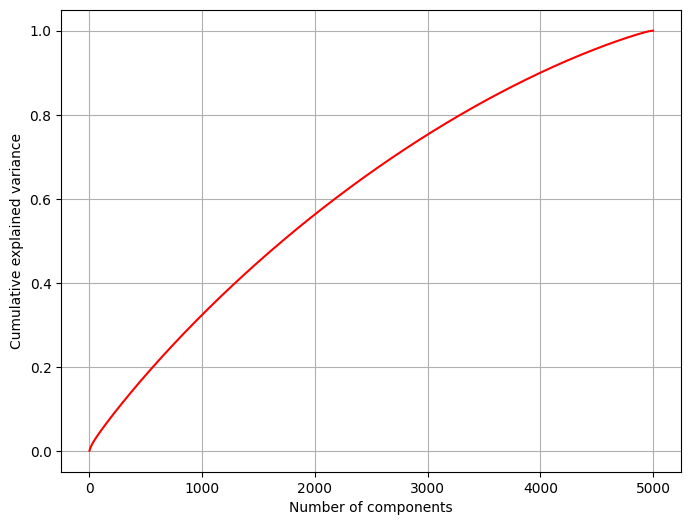

In [36]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(NUM_COMPONENTS),variance_explained, color='r')
ax.grid(True)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")

In [37]:
final_pca = PCA(0.9)
reduced_90 = final_pca.fit_transform(scaled_X_train) # Number of Components explaining 90% variance in the training data

In [38]:
reduced_90_test = final_pca.transform(scaled_X_test)

In [39]:
reduced_90.shape

(35043, 3999)

In [40]:
final_pca = PCA(0.8)
reduced_80 = final_pca.fit_transform(scaled_X_train) # Number of Components explaining 80% variance in the training data

In [41]:
reduced_80.shape

(35043, 3290)

## Model Training

In [2]:
pip install -U scikit-learn

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

In [44]:
# LOGISTIC REGRESSION with the the 90% variance data
from sklearn.linear_model import LogisticRegression
log_model_pca = LogisticRegression()
log_model_pca.fit(reduced_90, y_train)
preds_log_model_pca = log_model_pca.predict(reduced_90_test)
print(classification_report(y_test, preds_log_model_pca))
# Change the first argument to 'preds_log_model_pca'
confusion_matrix(preds_log_model_pca, y_test)

                   precision    recall  f1-score   support

              age       0.87      0.83      0.85       766
        ethnicity       0.89      0.86      0.87       801
           gender       0.76      0.79      0.78       788
not_cyberbullying       0.65      0.67      0.66       783
         religion       0.84      0.86      0.85       756

         accuracy                           0.80      3894
        macro avg       0.80      0.80      0.80      3894
     weighted avg       0.80      0.80      0.80      3894



array([[633,  16,  23,  45,  14],
       [ 12, 686,  20,  32,  18],
       [ 29,  26, 621, 123,  14],
       [ 79,  47,  98, 527,  58],
       [ 13,  26,  26,  56, 652]])

In [47]:
# LOGISTIC REGRESSION with the complete data
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
log_model = LogisticRegression(solver = 'saga')
param_grid = {'C': np.logspace(0, 10, 5)}
grid_log_model = HalvingGridSearchCV(log_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_log_model.fit(X_train_tfidf, y_train)
preds_grid_log_model = grid_log_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_log_model))

# Fix the arguments to the confusion_matrix function
confusion_matrix(y_test, preds_grid_log_model)

                   precision    recall  f1-score   support

              age       0.96      0.97      0.96       766
        ethnicity       0.98      0.98      0.98       801
           gender       0.92      0.84      0.88       788
not_cyberbullying       0.80      0.85      0.82       783
         religion       0.94      0.96      0.95       756

         accuracy                           0.92      3894
        macro avg       0.92      0.92      0.92      3894
     weighted avg       0.92      0.92      0.92      3894



array([[743,   1,   3,  18,   1],
       [  2, 782,   2,  13,   2],
       [  1,   6, 660, 113,   8],
       [ 28,   7,  49, 666,  33],
       [  1,   2,   2,  25, 726]])

In [48]:
grid_log_model.best_estimator_ # C = 1

LogisticRegression(solver='saga')

In [50]:
# SUPPORT VECTOR MACHINES
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
C = [1e-5, 1e-4, 1e-2, 1e-1, 1]
param_grid = {'C': C}
grid_svm_model = HalvingGridSearchCV(svm_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_svm_model.fit(X_train_tfidf, y_train)
preds_grid_svm_model = grid_svm_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_svm_model))
confusion_matrix(y_test, preds_grid_svm_model)

                   precision    recall  f1-score   support

              age       0.94      0.98      0.96       766
        ethnicity       0.97      0.98      0.98       801
           gender       0.94      0.81      0.87       788
not_cyberbullying       0.79      0.85      0.82       783
         religion       0.95      0.96      0.96       756

         accuracy                           0.92      3894
        macro avg       0.92      0.92      0.92      3894
     weighted avg       0.92      0.92      0.92      3894



array([[754,   1,   1,  10,   0],
       [  2, 783,   2,  13,   1],
       [  3,   7, 637, 133,   8],
       [ 39,  11,  36, 665,  32],
       [  1,   2,   1,  23, 729]])

In [55]:
grid_svm_model.best_estimator_

LinearSVC(C=0.1)

In [58]:
# NEURAL NETWORKS
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(activation = 'logistic', max_iter = 10)  # Sigmoid Activation Function
param_grid = {'learning_rate_init': [0.001, 0.0015, 0.002, 0.0025]}
grid_nn_model = HalvingGridSearchCV(nn_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_nn_model.fit(X_train_tfidf, y_train)
preds_grid_nn_model = grid_nn_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_nn_model))
# Fix the arguments to the confusion_matrix function
confusion_matrix(y_test, preds_grid_nn_model)

                   precision    recall  f1-score   support

              age       0.96      0.96      0.96       766
        ethnicity       0.97      0.97      0.97       801
           gender       0.89      0.84      0.87       788
not_cyberbullying       0.80      0.83      0.81       783
         religion       0.95      0.95      0.95       756

         accuracy                           0.91      3894
        macro avg       0.91      0.91      0.91      3894
     weighted avg       0.91      0.91      0.91      3894



array([[736,   5,   4,  21,   0],
       [  3, 778,   4,  14,   2],
       [  6,   7, 664, 103,   8],
       [ 24,   8,  68, 652,  31],
       [  0,   5,   3,  30, 718]])

In [59]:
grid_nn_model.best_estimator_

MLPClassifier(activation='logistic', learning_rate_init=0.002, max_iter=10)

In [63]:
# RANDOM FORESTS
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state = 42)
n_estimators = [64, 100, 128]
bootstrap = [True, False] # Bootstrapping is true by default
param_grid = {'n_estimators': n_estimators, 'bootstrap': bootstrap}
grid_rf_model = HalvingGridSearchCV(rf_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_rf_model.fit(X_train_tfidf, y_train)
preds_grid_rf_model = grid_rf_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_rf_model))
confusion_matrix(y_test, preds_grid_rf_model)

                   precision    recall  f1-score   support

              age       0.98      0.98      0.98       766
        ethnicity       0.98      0.98      0.98       801
           gender       0.92      0.86      0.89       788
not_cyberbullying       0.81      0.86      0.84       783
         religion       0.95      0.96      0.96       756

         accuracy                           0.93      3894
        macro avg       0.93      0.93      0.93      3894
     weighted avg       0.93      0.93      0.93      3894



array([[747,   3,   1,  15,   0],
       [  2, 784,   1,  13,   1],
       [  0,   3, 676, 105,   4],
       [ 14,   4,  53, 676,  36],
       [  1,   2,   3,  21, 729]])

In [64]:
grid_rf_model.best_estimator_

RandomForestClassifier(n_estimators=128, random_state=42)

In [67]:
# NAIVE - BAYES
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
preds_nb_model = nb_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_nb_model))
confusion_matrix(y_test, preds_nb_model)

                   precision    recall  f1-score   support

              age       0.81      0.97      0.88       766
        ethnicity       0.88      0.91      0.90       801
           gender       0.86      0.80      0.83       788
not_cyberbullying       0.83      0.55      0.66       783
         religion       0.81      0.96      0.88       756

         accuracy                           0.84      3894
        macro avg       0.84      0.84      0.83      3894
     weighted avg       0.84      0.84      0.83      3894



array([[745,   3,   2,  10,   6],
       [ 26, 730,   5,  12,  28],
       [ 25,  38, 634,  56,  35],
       [118,  49,  85, 432,  99],
       [  4,   6,   7,  13, 726]])

Random Forests turns out to be the best performing classifier out of all.

## Pipeline Creation

In [68]:
# Creating a pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf', TfidfVectorizer(max_features = 5000)), ('rf_model', RandomForestClassifier(n_estimators = 128, random_state = 42))])
pipe.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('rf_model',
                 RandomForestClassifier(n_estimators=128, random_state=42))])

In [69]:
pipe.predict(["@abc Hey man! Great match today. Your smashes were spot on. Let's continue playing together. \
               #badminton #brotherhood #men #doubles"])

array(['not_cyberbullying'], dtype=object)

## Note: The following tweets have been taken from the internet just to demonstrate the working of our Machine Learning Model. We haven't made any of them up. We believe in equality and don't discriminate on any grounds. We're strongly against all the types of bullying.

In [71]:
pipe.predict(["Going to Africa. Hope I don't get AIDS. Just kidding. I'm white!"])

array(['ethnicity'], dtype=object)

In [72]:
pipe.predict(["Muslims should be punished. We are not doing enough to rid us of those filthy animals."])

array(['religion'], dtype=object)

In [73]:
pipe.predict(["@abc Man you don't have any facial hair. You look like a fucking 9 year old school boy! #clown #idiot"])

array(['age'], dtype=object)

In [74]:
pipe.predict(["@abc shut up gay boy"])

array(['gender'], dtype=object)